In [222]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
import os
import seaborn as seaborn
import math
import datetime
from folium.plugins import BeautifyIcon
from folium.plugins import FeatureGroupSubGroup
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from ipywidgets import interact, Dropdown
from shapely.geometry import Point

In [223]:
train_data = pd.read_csv('eq_dataset_jp.csv')
train_df = train_data[["time", "place", "latitude", "longitude", "depth", "mag"]]
train_df = train_df[~train_df['place'].str.contains("Russia", na = False)] # remove Russia
train_df = train_df[~train_df['place'].str.contains("China", na = False)] # remove China 
train_df = train_df[~train_df['place'].str.contains("Korea", na = False)] # remove Korea
train_df['time'] = pd.to_datetime(train_df['time']).dt.strftime('%Y-%m-%d %H:%M:%S')
print(train_df.head())
train_df.to_csv('clean_eq_dataset_jp.csv', index=False)

## for more information about magnetude types, please refer to https://www.usgs.gov/natural-hazards/earthquake-hazards/science/magnitude-types?qt-science_center_objects=0#qt-science_center_objects


                  time                           place  latitude  longitude  \
1  2018-11-26 23:33:50         3km SSW of Sakai, Japan   36.0733   139.7830   
2  2018-11-26 13:04:02      26km SSE of Ofunato, Japan   38.8576   141.8384   
4  2018-11-25 09:19:05   9km SW of Komatsushima, Japan   33.9500   134.4942   
6  2018-11-23 14:30:14        29km ENE of Iwaki, Japan   37.1821   141.1721   
7  2018-11-23 07:19:51  250km N of Chichi-shima, Japan   29.3424   142.3121   

   depth  mag  
1  48.82  4.8  
2  50.56  4.5  
4  38.19  4.6  
6  46.76  5.2  
7  10.00  4.7  


In [224]:
# Visualization of significant Earthquakes in Japan from 2001 through 2018
major_cities = [
    {"name": "Tokyo", "latitude": 35.6895, "longitude": 139.6917},
    {"name": "Osaka", "latitude": 34.6937, "longitude": 135.5023},
    {"name": "Kyoto", "latitude": 35.0116, "longitude": 135.7681},
    {"name": "Nagoya", "latitude": 35.1815, "longitude": 136.9066},
    {"name": "Sapporo", "latitude": 43.0618, "longitude": 141.3545},
    {"name": "Fukuoka", "latitude": 33.5904, "longitude": 130.4017},
    {"name": "Hiroshima", "latitude": 34.3853, "longitude": 132.4553},
    {"name": "Sendai", "latitude": 38.2682, "longitude": 140.8694},
    
]

def get_color(magnitude):
    if magnitude < 5.0:
        return 'orange'
    elif 5.0 <= magnitude < 7.0:
        return 'red'
    else:
        return 'darkred'
    
def calculate_radius(magnitude):
    # formula: area ~ 10^(magnitude - 5) km^2
    # visualizing estimated area as a circle: r ~ sqrt(area / pi)
    import math
    area = 10 ** (magnitude - 5)
    radius_km = math.sqrt(area / math.pi) * 1000
    return radius_km

# Function to update the map with filters
@interact(year=Dropdown(options=['All'] + list(range(2001, 2019)), value='All', description="Year:"), 
          min_magnitude=(3.0, 9.0, 0.1))
def update_map(year='All', min_magnitude=5.5):
    # Filter earthquakes by year and minimum magnitude
    if year == 'All':
        filtered_earthquakes = train_df[train_df['mag'] >= min_magnitude]
    else:
        filtered_earthquakes = train_df[(train_df['mag'] >= min_magnitude) & (pd.to_datetime(train_df['time']).dt.year == year)]

    # Create the map
    earthquake_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles="CartoDB positron", width=1250)

    # Add circles to the map
    for idx, earthquake in filtered_earthquakes.iterrows():
        tooltip_info = f"Time: {earthquake['time']}<br>Place: {earthquake['place']}<br>Magnitude: {earthquake['mag']}"
        circle_color = get_color(earthquake['mag'])
        circle_radius = calculate_radius(earthquake['mag'])  # Calculate radius based on magnitude
        folium.Circle(
            location=[earthquake['latitude'], earthquake['longitude']], 
            radius=circle_radius, 
            color=circle_color, 
            fill=True,
            fill_color=circle_color,
            tooltip=tooltip_info
        ).add_to(earthquake_map)

    for city in major_cities:
        folium.Marker(
            location=[city['latitude'], city['longitude']],
            popup=city['name'],
            icon=folium.Icon(icon="star", color="blue")
        ).add_to(earthquake_map)

    # Aggiungere una legenda personalizzata
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 150px; 
                background-color: white; z-index:9999; font-size:14px; 
                border:2px solid grey; padding: 10px;">
        <b>Magnitude Legend:</b><br>
        <i style="background: orange; color: orange;">&nbsp;&nbsp;&nbsp;&nbsp;</i> < 5.0<br>
        <i style="background: red; color: red;">&nbsp;&nbsp;&nbsp;&nbsp;</i> 5.0 - 6.9<br>
        <i style="background: darkred; color: darkred;">&nbsp;&nbsp;&nbsp;&nbsp;</i> >= 7.0
    </div>
    '''
    earthquake_map.get_root().html.add_child(folium.Element(legend_html))

    # Mostrare la mappa
    display(earthquake_map)

    


interactive(children=(Dropdown(description='Year:', options=('All', 2001, 2002, 2003, 2004, 2005, 2006, 2007, …

In [225]:
# Heatmap

earthquake_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles="CartoDB positron", width=1250)
heat_data = [[row['latitude'], row['longitude'], row['mag']] for index, row in train_df.iterrows()]

#Add the heat map to the map
HeatMap(heat_data).add_to(earthquake_map)
earthquake_map

In [226]:
# Clustered Map

def get_color(magnitude):
    if magnitude < 5.0:
        return 'orange'
    elif 5.0 <= magnitude < 7.0:
        return 'red'
    else:
        return 'darkred'
    
def calculate_radius(magnitude):
    # formula: area ~ 10^(magnitude - 5) km^2
    # visualizing estimated area as a circle: r ~ sqrt(area / pi)
    area = 10 ** (magnitude - 5)
    radius_km = math.sqrt(area / math.pi) * 1000
    return radius_km

# Function to update the map with filters
@interact(year=Dropdown(options=['All'] + list(range(2001, 2019)), value='All', description="Year:"), 
          min_magnitude=(3.0, 9.0, 0.1))
def update_map(year='All', min_magnitude=5.5):
    # Filter earthquakes by year and minimum magnitude
    if year == 'All':
        filtered_earthquakes = train_df[train_df['mag'] >= min_magnitude]
    else:
        filtered_earthquakes = train_df[(train_df['mag'] >= min_magnitude) & (pd.to_datetime(train_df['time']).dt.year == year)]

    # Create the map
    earthquake_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles="CartoDB positron", width=1250)

    marker_cluster = MarkerCluster().add_to(earthquake_map)

    # Add circles to the map
    for idx, earthquake in filtered_earthquakes.iterrows():
        tooltip_info = f"Time: {earthquake['time']}<br>Place: {earthquake['place']}<br>Magnitude: {earthquake['mag']}"
        folium.CircleMarker(
            location=[earthquake['latitude'], earthquake['longitude']], 
            radius=5,  # Fixed radius for better clustering visualization
            color=get_color(earthquake['mag']), 
            fill=True,
            fill_color=get_color(earthquake['mag']),
            tooltip=tooltip_info
        ).add_to(marker_cluster)

    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 150px; 
                background-color: white; z-index:9999; font-size:14px; 
                border:2px solid grey; padding: 10px;">
        <b>Magnitude Legend:</b><br>
        <i style="background: orange; color: orange;">&nbsp;&nbsp;&nbsp;&nbsp;</i> < 5.0<br>
        <i style="background: red; color: red;">&nbsp;&nbsp;&nbsp;&nbsp;</i> 5.0 - 6.9<br>
        <i style="background: darkred; color: darkred;">&nbsp;&nbsp;&nbsp;&nbsp;</i> >= 7.0
    </div>
    '''
    earthquake_map.get_root().html.add_child(folium.Element(legend_html))

    # Mostrare la mappa

    display(earthquake_map)

interactive(children=(Dropdown(description='Year:', options=('All', 2001, 2002, 2003, 2004, 2005, 2006, 2007, …

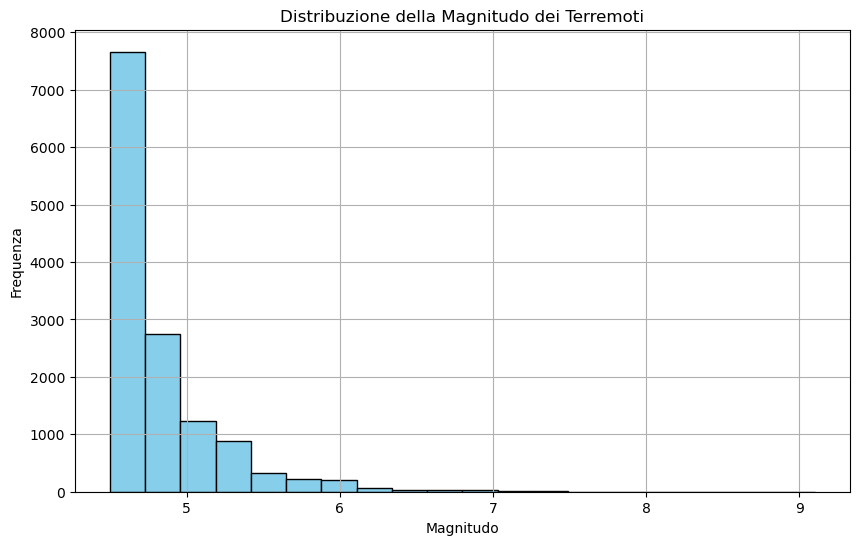

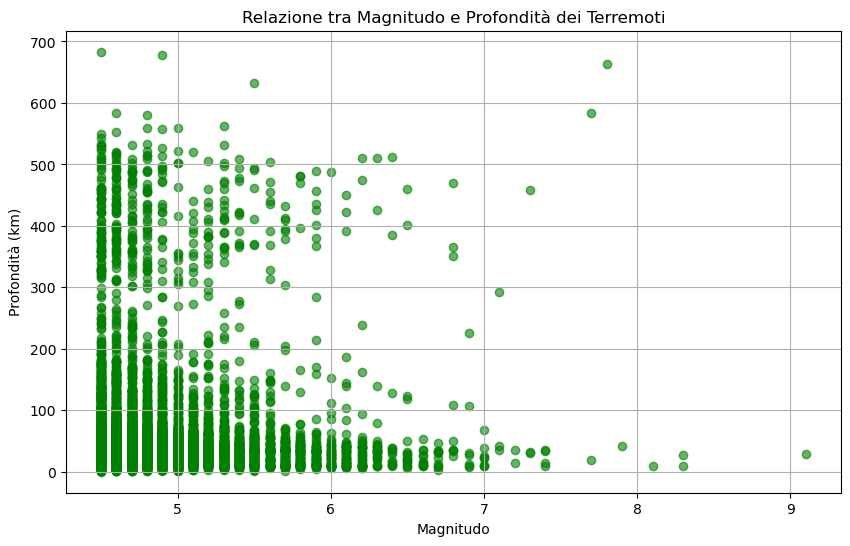

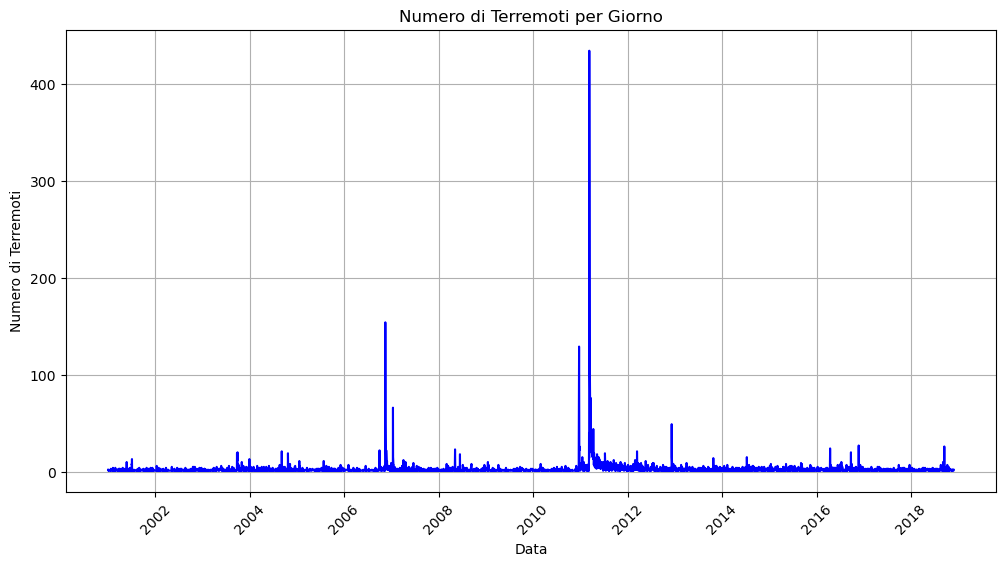

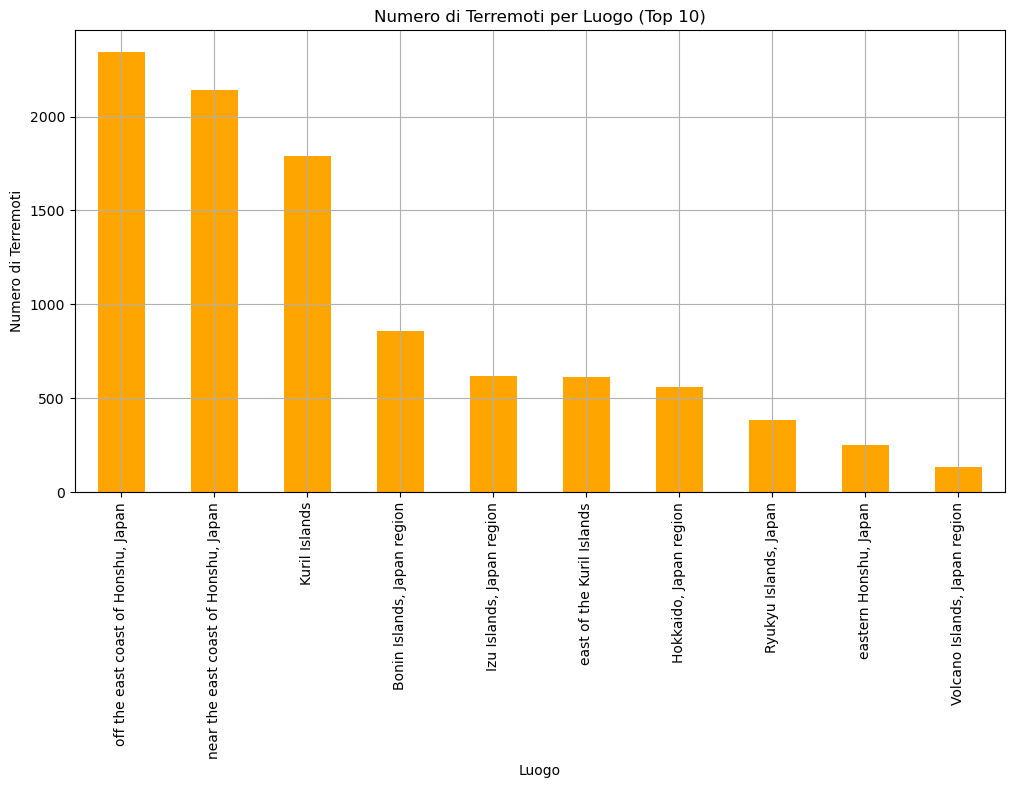

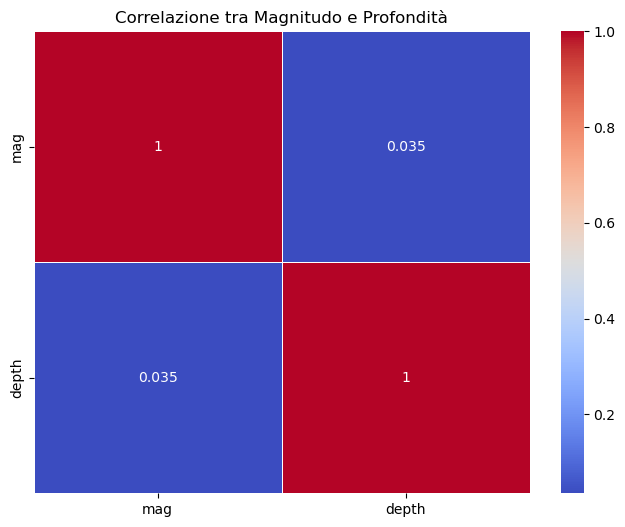

In [227]:
output_dir = "graphs"
os.makedirs(output_dir, exist_ok=True)


# Istogramma magnitudo dei terremoti
plt.figure(figsize=(10, 6))
plt.hist(train_df['mag'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuzione della Magnitudo dei Terremoti')
plt.xlabel('Magnitudo')
plt.ylabel('Frequenza')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'istogramma_magnitudo.png'))  # Salva l'immagine



# Scatter plot tra Magnitudo e Profondità
plt.figure(figsize=(10, 6))
plt.scatter(train_df['mag'], train_df['depth'], alpha=0.6, color='green')
plt.title('Relazione tra Magnitudo e Profondità dei Terremoti')
plt.xlabel('Magnitudo')
plt.ylabel('Profondità (km)')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'scatter_magnitudo_profondita.png'))  # Salva l'immagine




# Converti la colonna 'time' in formato datetime
train_df['time'] = pd.to_datetime(train_df['time'])

# Conteggio dei terremoti per giorno
earthquake_by_day = train_df.groupby(train_df['time'].dt.date).size()

# Plot del numero di terremoti nel tempo
plt.figure(figsize=(12, 6))
plt.plot(earthquake_by_day.index, earthquake_by_day.values, color='blue')
plt.title('Numero di Terremoti per Giorno')
plt.xlabel('Data')
plt.ylabel('Numero di Terremoti')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'terremoti_per_giorno.png'))  # Salva l'immagine




# Conteggio dei terremoti per luogo
earthquake_by_place = train_df['place'].value_counts().head(10)  # I primi 10 luoghi con più terremoti

# Bar plot dei terremoti per luogo
plt.figure(figsize=(12, 6))
earthquake_by_place.plot(kind='bar', color='orange')
plt.title('Numero di Terremoti per Luogo (Top 10)')
plt.xlabel('Luogo')
plt.ylabel('Numero di Terremoti')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'terremoti_per_luogo.png'))  # Salva l'immagine




# Calcolare la correlazione
correlation = train_df[['mag', 'depth']].corr()

# Heatmap della correlazione
plt.figure(figsize=(8, 6))
seaborn.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlazione tra Magnitudo e Profondità')
plt.savefig(os.path.join(output_dir, 'correlazione_heatmap.png'))  # Salva l'immagine




In [228]:
# GeoPandas
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

major_cities = {
    'Tokyo': [35.6762, 139.6503],
    'Osaka': [34.6937, 135.5023],
    'Kyoto': [35.0116, 135.7681],
    'Nagoya': [35.1815, 136.9066],
    'Sapporo': [43.0618, 141.3545],
    'Fukuoka': [33.5902, 130.4017],
    'Hiroshima': [34.3853, 132.4553],
    'Sendai': [38.2682, 140.8694],
    'Naha (Okinawa)': [26.2124, 127.6809],
    'Muroto (Kochi)': [33.3714, 134.1431]
}

geometry = [Point(xy) for xy in zip(train_df['longitude'], train_df['latitude'])]
geo_df = gpd.GeoDataFrame(train_df, crs={'init': 'epsg:4326'}, geometry=geometry)

# prepare data for clustering and performing DBSCAN clustering on data
coords = np.column_stack((geo_df['latitude'], geo_df['longitude']))
coords_scaled = StandardScaler().fit_transform(coords)

# db = DBSCAN(eps=0.5, min_samples=10).fit(coords_scaled)
# geo_df['cluster'] = db.labels_

# calculating risk scores for major cities

risk_scores = {}

for city, coords in major_cities.items():

    city_point = Point(coords[1], coords[0])
    nearby_eqs = geo_df[geo_df.geometry.distance(city_point) < 2.0]

    if(len(nearby_eqs) > 0):
        distances = nearby_eqs.geometry.distance(city_point)
        risk_score = sum(nearby_eqs['mag'] / (1 + distances))
        normalized_score = np.log1p(risk_score)

    else:
        normalized_score = 0

    risk_scores[city] = normalized_score

print(risk_scores)

# Visualization of significant Earthquakes in Japan from 2001 through 2018
major_cities = [
    {"name": "Tokyo", "latitude": 35.6895, "longitude": 139.6917},
    {"name": "Osaka", "latitude": 34.6937, "longitude": 135.5023},
    {"name": "Kyoto", "latitude": 35.0116, "longitude": 135.7681},
    {"name": "Nagoya", "latitude": 35.1815, "longitude": 136.9066},
    {"name": "Sapporo", "latitude": 43.0618, "longitude": 141.3545},
    {"name": "Fukuoka", "latitude": 33.5904, "longitude": 130.4017},
    {"name": "Hiroshima", "latitude": 34.3853, "longitude": 132.4553},
    {"name": "Sendai", "latitude": 38.2682, "longitude": 140.8694},
    {"name": "Naha (Okinawa)", "latitude": 26.2124, "longitude": 127.6809},
    {"name": "Muroto (Kochi)", "latitude": 33.3714, "longitude": 134.1431}
]

def get_color(magnitude):
    if magnitude < 5.0:
        return 'orange'
    elif 5.0 <= magnitude < 7.0:
        return 'red'
    else:
        return 'darkred'
    
def calculate_radius(magnitude):
    # formula: area ~ 10^(magnitude - 5) km^2
    # visualizing estimated area as a circle: r ~ sqrt(area / pi)
    import math
    area = 10 ** (magnitude - 5)
    radius_km = math.sqrt(area / math.pi) * 1000
    return radius_km

# Function to update the map with filters
@interact(year=Dropdown(options=['All'] + list(range(2001, 2019)), value='All', description="Year:"), 
          min_magnitude=(3.0, 9.0, 0.1))
def update_map(year='All', min_magnitude=5.5):
    # Filter earthquakes by year and minimum magnitude
    if year == 'All':
        filtered_earthquakes = train_df[train_df['mag'] >= min_magnitude]
    else:
        filtered_earthquakes = train_df[(train_df['mag'] >= min_magnitude) & (pd.to_datetime(train_df['time']).dt.year == year)]

    # Create the map
    earthquake_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles="CartoDB positron", width=1250)

    # Add circles to the map
    for idx, earthquake in filtered_earthquakes.iterrows():
        tooltip_info = f"Time: {earthquake['time']}<br>Place: {earthquake['place']}<br>Magnitude: {earthquake['mag']}"
        circle_color = get_color(earthquake['mag'])
        circle_radius = calculate_radius(earthquake['mag'])  # Calculate radius based on magnitude
        folium.Circle(
            location=[earthquake['latitude'], earthquake['longitude']], 
            radius=circle_radius, 
            color=circle_color, 
            fill=True,
            fill_color=circle_color,
            tooltip=tooltip_info
        ).add_to(earthquake_map)

    for city in major_cities:
        tooltip_info2 = f"City: {city['name']}<br>Risk Score: {risk_scores[city['name']]:.2f}"
        folium.Marker(
            location=[city['latitude'], city['longitude']],
            popup=city['name'],
            icon=folium.Icon(icon="star", color="blue"),
            tooltip=tooltip_info2
        ).add_to(earthquake_map)

    # Aggiungere una legenda personalizzata
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 150px; 
                background-color: white; z-index:9999; font-size:14px; 
                border:2px solid grey; padding: 10px;">
        <b>Magnitude Legend:</b><br>
        <i style="background: orange; color: orange;">&nbsp;&nbsp;&nbsp;&nbsp;</i> < 5.0<br>
        <i style="background: red; color: red;">&nbsp;&nbsp;&nbsp;&nbsp;</i> 5.0 - 6.9<br>
        <i style="background: darkred; color: darkred;">&nbsp;&nbsp;&nbsp;&nbsp;</i> >= 7.0
    </div>
    '''
    earthquake_map.get_root().html.add_child(folium.Element(legend_html))
    heat_data = [[row['latitude'], row['longitude'], row['mag']] for index, row in train_df.iterrows()]

    #Add the heat map to the map
    HeatMap(heat_data).add_to(earthquake_map)
    # Mostrare la mappa
    display(earthquake_map)



c:\Users\david\miniconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\david\AppData\Local\Temp\ipykernel_12124\4139856077.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby_eqs = geo_df[geo_df.geometry.distance(city_point) < 2.0]
C:\Users\david\AppData\Local\Temp\ipykernel_12124\4139856077.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = nearby_eqs.geometry.dis

{'Tokyo': np.float64(8.041362970275136), 'Osaka': np.float64(5.535703260629446), 'Kyoto': np.float64(5.532539985158755), 'Nagoya': np.float64(5.805588795092435), 'Sapporo': np.float64(6.515819292575503), 'Fukuoka': np.float64(5.753415315490471), 'Hiroshima': np.float64(5.084860170239282), 'Sendai': np.float64(8.426928534396607), 'Naha (Okinawa)': np.float64(6.767464258995582), 'Muroto (Kochi)': np.float64(4.630004207225378)}


C:\Users\david\AppData\Local\Temp\ipykernel_12124\4139856077.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = nearby_eqs.geometry.distance(city_point)


interactive(children=(Dropdown(description='Year:', options=('All', 2001, 2002, 2003, 2004, 2005, 2006, 2007, …